# <center><u>Bayesian Modeling for the Busy Earth Scientist</u></center>

Part of my day-to-day work, involves assessing predictive models used to infer geophysical variables from remote sensing data. The models,  training data, and the practices used suffer from the following issues, reducing the reliability of predictions: 


* Models: 
    1. Models are opaque, with implicit (read unstated) assumptions. This makes either understanding them or replicating their development challenging. 
    2. When available, the quantification of prediction uncertainty is the result of an ad-hoc approach based on unverified statistical assumptions.
    3. Additional contextual information and/or domain knowledge cannot be included to constrain predictions.
    4. When multiple models are available, the methodology for comparing/selecting/blending  models is lacking.<br><br>

* Training Data:
    1. Data is noisy collected using a variety of methods.
    2. Data sets used for training global models are small, occasionally biased toward specific oceanographic biomes.
    3. High risk of over-fitting.<br><br>
    
* Practices:
    1. Over-emphasis on fitting training data:
    2. Arbitrary outlier definition and removal;
    3. Data hacking to improve model fit
    4. High risk of over-fitting

To address these concerns and attempt to overhaul model development in my group, I opted for  Bayesian modeling. While initially challenging to get into, after years of frequentist dogma. I quickly found this approach to be quite intuitive. To help my colleagues understand the approach I wrote a series of tutorial notebooks highlighting both general concepts and specific examples dealing with the prediction of biogeophysical quantities from satellite remote sensing data. The present notebook is the introductory tutorial, with the content displayed below.

<a id='TOP'></a>

## Notebook Contents


1. [Basics: Joint probability, Inverse probability and Bayes' Theorem](#BASIC)
2. [Practical Example: Inferring Chl Distribution](#JustCHL)
    1. [Grid Approximation](#GRID)
        1. [Impact of priors](#PriorImpact)
        2. [Impact of data set size](#DataImpact)
    2. [MCMC](#MCMC)
    3. [PyMC3](#PyMC3)
3. [Regression](#Reg)
    1. [Data Preparation](#DataPrep)
    2. [Regression in PyMC3](#RegPyMC3)
    3. [Checking Priors](#PriorCheck)
    4. [Model Fitting](#Mining)
    5. [Flavors of Uncertainty](#UNC)
4. [Conclusion](#Conclusion)
5. [To be Continued...](#Next)


Get the full notebook [here]()

In [ ]:
import pickle
import warnings
import sys
from IPython.display import Image, HTML

import pandas as pd
import numpy as np
from scipy.stats import norm, uniform
import pymc3 as pm
from theano import shared

import seaborn as sb
import matplotlib.pyplot as pl
from matplotlib import rcParams
from matplotlib import ticker as mtick
import cmocean.cm as cmo
import arviz as ar

In [2]:
print('Versions:')
print('---------')
print(f'python:  {sys.version.split("|")[0]}')
print(f'numpy:   {np.__version__}')
print(f'pandas:  {pd.__version__}')
print(f'seaborn: {sb.__version__}')
print(f'pymc3:   {pm.__version__}')
print(f'arviz:   {ar.__version__}')

Versions:
---------
python:  3.6.8 
numpy:   1.15.4
pandas:  0.24.0
seaborn: 0.9.0
pymc3:   3.6
arviz:   0.3.2


In [3]:
%matplotlib inline
warnings.filterwarnings('ignore',  category=FutureWarning)

<a id='BASIC'></a>
[Back to Contents](#TOP)

### 1. <u>Basics</u>:

#### $\Rightarrow$Joint probability, Inverse probability and Bayes'  rule
<br>
Here's a circumspect list of basic concepts that will help understand what is going on:

* Joint probability of two events $A$, $B$:
$$P(A, B)=P(A|B)\times P(B)=P(B|A)\times P(A)$$

* If A and B are independent: $$P(A|B) = P(A)\ \leftrightarrow P(A,B) = P(A)\times P(B)$$

* Inverse probability:$$\boxed{P(A|B) = \frac{P(B|A) \times P(A)}{P(B)}}$$ 

$\rightarrow$Inverse probability is handy when $P(A|B)$ is desired but hard to compute, but its counterpart, $P(B|A)$ is easy to compute. The result above which is derived directly from the joint probability formulation above, is referred to as Bayes' theorem/rule. One might ask next, how this is used to build a "Bayesian model."

#### $\Rightarrow$Extending Bayes' theorem to model building
<br>
Given a model:

* Hypotheses (\\(H\\)): values that model parameters can take
* \\( P(H) \\): probability of each value in H
* Data (\\( D \\))
* \\( P(D) \\): probability of the data

Approach 
* formulate initial opinion on what $H$ might include and with what probability, $P(H)$
* collect data ($D$) 
* update $P(H)$ using $D$ and Bayes' theorem

$$\frac{P(H)\times P(D|H)}{P(D)} = P(H|D)$$

Getting rid of the evidence, P(D), turns out to simplify computations quite a bit. P(D) hereafter will be considered a normalization constant and will therefore be dropped; without prejudice, as it turns out.
$$\boxed{P(H) \times P(D|H) \propto P(H|D)}$$


Note that what we care about is updating H, model parameters, after evaluating some observations.
Let's go over each of the elements of this proportionality statement.

#### The prior
$$\underline{P(H)}\times P(D|H) \propto P(H|D)$$

* $H$: set of values that model parameters might take with corresponding probability $P(H)$

* We can use a probability distribution to express $P(H)$ as shown below

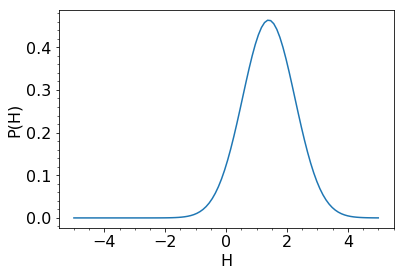

In [5]:
# build 1D grid of possible values
h = np.linspace(-5, 5, num=100)
μ_prior = 1.4 
σ_prior = 0.86
# compute probability at each a h
p_h = norm.pdf(h, loc=μ_prior, scale=σ_prior) 
pl.plot(h, p_h); pl.ylabel('P(H)'); pl.xlabel('H');

#### The likelihood

$$P(H)\times \underline{P(D|H)} \propto  P(H|D)$$


* probability of the data, \\(D\\), *given* \\(H\\)
* in the frequentist framework, this quantity is maximized to find the "best" fit \\( \rightarrow \\) NOT DONE HERE!
* we don't engage in likelihood maximization because:
    * doing so means finding a particular value for H, whereas we're interested in the updated P(H) after evaluating data at hand.
    * moreover, data at hand may misrepresent the big picture

#### The posterior:

$$P(H)\times P(D|H) \propto \underline{P(H|D)}$$


* it's what we're after!!!
* updated probability of \\(H\\) after collecting \\(D\\)
* used as prior for next iteration \\(P(H|D)\rightarrow P(H)\\), when new data become available.
* $P(H|D)$ naturally yields uncertainty around the estimate via propagation.

A simple example will crystallize some of these concepts. So I will illustrate the mechanics of Bayesian inference by trying to discover the parameters that best describe the statistical distribution of marine phytoplankton chlorophyll.

<a id='JustCHL'></a>
[Back to Contents](#TOP)


## Under the hood: Inferring chlorophyll

The obvious way to compute the posterior distribution of a model parameter is to determine all the values of the parameter we're interested in. The next step is to initialize the corresponding probability of each value by stipulating a prior distribution. Finally, we update the prior distribution by evaluating the likelihood using observations on hand. This is referred to as Grid Approximation. Mechanistically, it is pretty straightforward; it is an approximation because the values are discretized to build a grid where probabilities are computed over each grid point. As the number of model parameters increases, however, grid approximation is subject to the [curse of dimensionality](https://en.wikipedia.org/wiki/Curse_of_dimensionality), making it a poor choice for any serious modeling. I'll demonstrate it once below for illustration, and move to better approaches later on.
<a id='GRID'></a>

First, I load data stored in a pandas dataframe that contains among other things, log-transformed phytoplankton chlorophyll (*chl_l*) values measured during oceanographic cruises around the world.

In [6]:
df_data = pd.read_pickle('./pickleJar/df_logMxBlues.pkl')

In [7]:
df_data[['MxBl-Gr', 'chl_l']].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4459 entries, 0 to 4458
Data columns (total 2 columns):
MxBl-Gr    4453 non-null float64
chl_l      4127 non-null float64
dtypes: float64(2)
memory usage: 104.5 KB


here are two columns. *MxBl-Gr* is a blue-to-green ratio that will serve as predictor of chlorophyll when I address regression. For now, *MxBl-Gr* is ignored, only *chl_l* is of interest. Here is what the distribution of *chl_l*, smoothed by kernel density estimation, looks like:

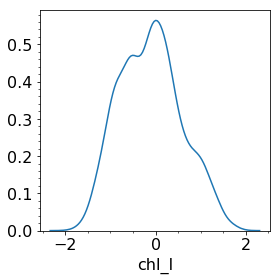

In [8]:
f, ax = pl.subplots(figsize=(4,4))
sb.kdeplot(df_data.chl_l, ax=ax, legend=False);
ax.set_xlabel('chl_l');
f.tight_layout()
f.savefig('./figJar/Presentation/fig1_chl.svg', dpi=300, format='svg')

For this example I simply want to approximate the distribution of *chl_l* following these steps: 

* Define a model to approximate the process that generates the observations
    * Theory: data generation is well approximated by a Gaussian
    * Hypotheses (\\(H\\)) therefore include 2 vectors; mean \\(\mu\\) and standard deviation \\(\sigma\\)
* Build the grid of model parameters
    * 2D grid of \\((\mu, \sigma)\\) pair
* Propose priors
    * define priors for both \\(\mu\\) and \\(\sigma\\)
* Compute likelihood
* Compute posterior

Grid approximation needs a grid so I'll build a \\(200x200\\) grid with axes \\(\mu\\) (mean) and \\(\sigma\\) (std. dev.)

In [9]:
μ = np.linspace(-2, 2, num=200) # μ-axis
σ = np.linspace(0, 2, num=200) # σ-axis

For ease of manipulation I will use a pandas DataFrame to hold the results of the prior definition, likelihood and posterior computation at each grid point. Here is the definition of the grid...

In [10]:
df_grid = pd.DataFrame([[μ_i, σ_i]
                        for σ_i in σ for μ_i in μ], columns=['μ', 'σ'])

... and here is what it looks like.

In [11]:
print(df_grid.shape)
df_grid.head(7)

(40000, 2)


,μ,σ
0,-2.000000,0.0
1,-1.979899,0.0
2,-1.959799,0.0
3,-1.939698,0.0
4,-1.919598,0.0
5,-1.899497,0.0
6,-1.879397,0.0


Now I can define prior probabilities for both \\(\mu\\) and \\(\sigma\\). I will use a normal distribution for \\(\mu\\) and a uniform distribution for \\(\sigma\\) <br>
\\(\rightarrow \mu \sim \mathcal{N}(1, 1)\\): a gaussian distribution centered at 1, with an sd of 1<br>
\\(\rightarrow \sigma \sim \mathcal{U}(0, 2)\\): a uniform distribution bounded at 0 and 2<br>
Note that limits are enforced to keep the computation manageable and the results illustrative but could be, in a real world situation, choices guided by domain knowledge. The lines below show how to pass the grid defined above to the scipy.stats distribution functions to compute the prior at each grid point.

In [12]:
μ_prior = norm.logpdf(df_grid.μ, 1, 1)
σ_prior = uniform.logpdf(df_grid.σ, 0, 2)

Note that the code above computes the log of the prior probability of each parameter at each grid point. The parameters \\(\mu\\) and \\(\sigma\\) are assumed independent. Thus, according to the rules stipulated further above, the overall, i.e. joint prior probability at each grid point is just the product the individual prior probability at each grid point. Log-transforming probabilities means the joint probability of the entire grid can be computed by summing log probabilities followed by taking the exponent of the result. Doing so avoids problems like underflow.
I store both the joint log-probability and the log-probability at each grid point in the pandas dataframe with the code snippet below:

In [13]:
# log prior probability
df_grid['log_prior_prob'] = μ_prior + σ_prior
# straight prior probability
df_grid['prior_prob'] = np.exp(df_grid.log_prior_prob
                                - df_grid.log_prior_prob.max())

Since there are only two parameters, visualizing the joint prior probability is straighforward:

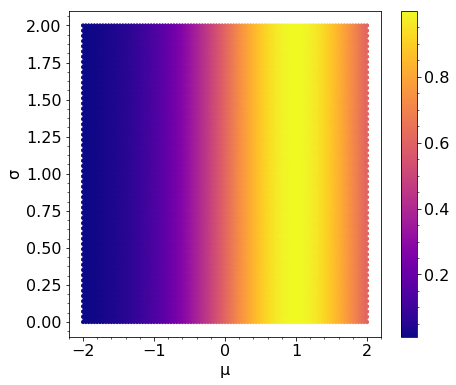

In [14]:
df_grid.plot.hexbin(x='μ', y='σ', C='prior_prob', figsize=(7,6),
                     cmap='plasma', sharex=False);

In the figure above looking down the \\(\sigma\\)-axis shows the 'wall' of uniform probability where none of the positive values, capped here at 2.0 has is expected to be more likely. Looking down the \\(\mu\\)-axis, on the other hand, reveals the gaussian peak around 1, within a grid of floats extending from -2.0 to 2.0. 
Once priors have been defined, the model is ready to be fed some data. The *chl_* loaded earlier had several thousand observations. Because grid approximation is computationally intensive, I'll only pick a handful of data. For reasons discussed further below, this will enable the comparison of the effects different priors can have on the final result.
I'll start by selecting 10 observations. 

In [15]:
sample_N = 10
df_data_s = df_data.dropna().sample(n=sample_N)

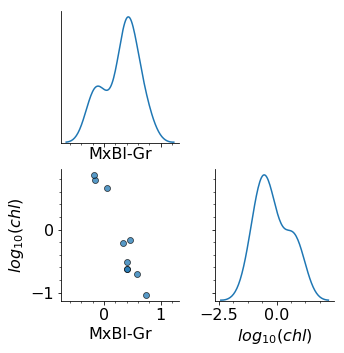

In [16]:
g = sb.PairGrid(df_data_s.loc[:,['MxBl-Gr', 'chl_l']],
                diag_sharey=False)
g.map_diag(sb.kdeplot, )
g.map_offdiag(sb.scatterplot, alpha=0.75, edgecolor='k');
make_lower_triangle(g)
g.axes[1,0].set_ylabel(r'$log_{10}(chl)$');
g.axes[1,1].set_xlabel(r'$log_{10}(chl)$');

Compute Log-Likelihood of the data given every  pair \\( ( \mu ,\sigma)\\). This is done by summing the log-probability of each datapoint, given each grid point; i.e. each \\((\mu, \sigma)\\) pair.

In [17]:
df_grid['LL'] = np.sum(norm.logpdf(df_data_s.chl_l.values.reshape(1, -1),
                                    loc=df_grid.μ.values.reshape(-1, 1),
                                    scale=df_grid.σ.values.reshape(-1, 1)
                                   ), axis=1)

#### Compute Posterior $P(\mu,\sigma\ | data) \propto P(data | \mu, \sigma) \times P(\mu, \sigma)$

In [18]:
# compute log-probability
df_grid['log_post_prob'] = df_grid.LL + df_grid.log_prior_prob
# convert to straight prob.
df_grid['post_prob'] = np.exp(df_grid.log_post_prob
                               - df_grid.log_post_prob.max())

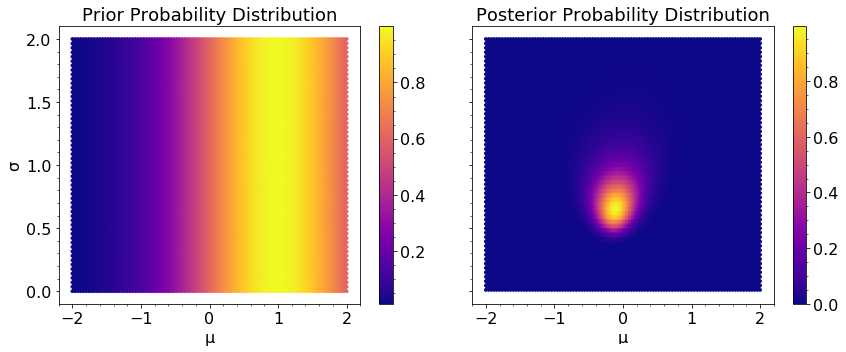

In [19]:
# Plot Multi-Dimensional Prior and Posterior
f, ax = pl.subplots(ncols=2, figsize=(12, 5), sharey=True)
df_grid.plot.hexbin(x='μ', y='σ', C='prior_prob',
                    cmap='plasma', sharex=False, ax=ax[0])
df_grid.plot.hexbin(x='μ', y='σ', C='post_prob',
                     cmap='plasma', sharex=False, ax=ax[1]);
ax[0].set_title('Prior Probability Distribution')
ax[1].set_title('Posterior Probability Distribution')
f.tight_layout()
f.savefig('./figJar/Presentation/grid1.svg')

<img src="figJar/Presentation/grid1.svg"/>

In [20]:
# Compute Marginal Priors and Posteriors for each Parameter
df_μ = df_grid.groupby(['μ']).sum().drop('σ', axis=1)[['prior_prob',
                                                        'post_prob']
                                                      ].reset_index()
df_σ = df_grid.groupby(['σ']).sum().drop('μ', axis=1)[['prior_prob',
                                                        'post_prob']
                                                      ].reset_index() 

# Normalize Probability Distributions
df_μ.prior_prob /= df_μ.prior_prob.max()
df_μ.post_prob /= df_μ.post_prob.max()
df_σ.prior_prob /= df_σ.prior_prob.max()
df_σ.post_prob /= df_σ.post_prob.max()

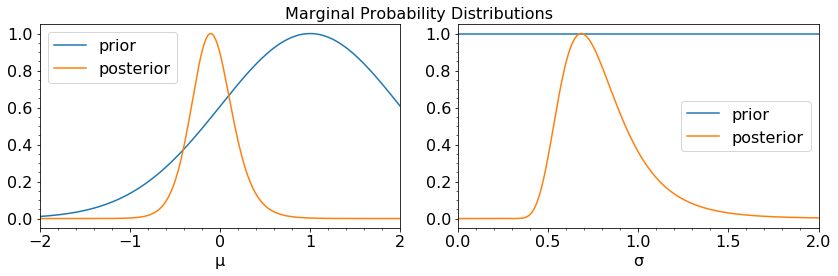

In [21]:
#Plot Marginal Priors and Posteriors
f, ax = pl.subplots(ncols=2, figsize=(12, 4))
df_μ.plot(x='μ', y='prior_prob', ax=ax[0], label='prior');
df_μ.plot(x='μ', y='post_prob', ax=ax[0], label='posterior')
df_σ.plot(x='σ', y='prior_prob', ax=ax[1], label='prior')
df_σ.plot(x='σ', y='post_prob', ax=ax[1], label='posterior');
f.suptitle('Marginal Probability Distributions', fontsize=16);
f.tight_layout(pad=2)
f.savefig('./figJar/Presentation/grid2.svg')

<img src="./figJar/Presentation/grid2.svg?modified=2"/>

[Back to Contents](#TOP)
<a id='PriorImpact'></a>

### Impact of Priors

In [22]:
def compute_bayes_framework(data, priors_dict):
    # build grid:
    μ = np.linspace(-2, 2, num=200)
    σ = np.linspace(0, 2, num=200)
    df_b = pd.DataFrame([[μ_i, σ_i] for σ_i in σ for μ_i in μ],
                        columns=['μ', 'σ'])
    # compute/store distributions
    μ_prior = norm.logpdf(df_b.μ, priors_dict['μ_mean'],
                          priors_dict['μ_sd'])
    σ_prior = uniform.logpdf(df_b.σ, priors_dict['σ_lo'],
                             priors_dict['σ_hi'])
    # compute joint prior
    df_b['log_prior_prob'] = μ_prior + σ_prior 
    df_b['prior_prob'] = np.exp(df_b.log_prior_prob
                                    - df_b.log_prior_prob.max())
    # compute log likelihood
    df_b['LL'] = np.sum(norm.logpdf(data.chl_l.values.reshape(1, -1),
                                    loc=df_b.μ.values.reshape(-1, 1),
                                    scale=df_b.σ.values.reshape(-1, 1)
                                   ), axis=1)
    # compute joint posterior
    df_b['log_post_prob'] = df_b.LL + df_b.log_prior_prob
    df_b['post_prob'] = np.exp(df_b.log_post_prob
                               - df_b.log_post_prob.max())
    return df_b


def plot_posterior(df_, ax1, ax2):
    df_.plot.hexbin(x='μ', y='σ', C='prior_prob',
                        cmap='plasma', sharex=False, ax=ax1)
    df_.plot.hexbin(x='μ', y='σ', C='post_prob',
                         cmap='plasma', sharex=False, ax=ax2);
    ax1.set_title('Prior Probability Distribution')
    ax2.set_title('Posterior Probability Distribution')
    
    
def plot_marginals(df_, ax1, ax2, plot_prior=True):
    """Compute marginal posterior distributions."""
    df_μ = df_.groupby(['μ']).sum().drop('σ',
                                         axis=1)[['prior_prob',
                                                  'post_prob']
                                                ].reset_index()
    df_σ = df_.groupby(['σ']).sum().drop('μ',
                                         axis=1)[['prior_prob',
                                                  'post_prob']
                                                ].reset_index() 
    
    # Normalize Probability Distributions
    df_μ.prior_prob /= df_μ.prior_prob.max()
    df_μ.post_prob /= df_μ.post_prob.max()
    df_σ.prior_prob /= df_σ.prior_prob.max()
    df_σ.post_prob /= df_σ.post_prob.max()

    #Plot Marginal Priors and Posteriors
    if plot_prior:
        df_μ.plot(x='μ', y='prior_prob', ax=ax1, label='prior');
        df_σ.plot(x='σ', y='prior_prob', ax=ax2, label='prior')
    df_μ.plot(x='μ', y='post_prob', ax=ax1, label='posterior')
    df_σ.plot(x='σ', y='post_prob', ax=ax2, label='posterior');

Try two priors:
1. $\mu \sim \mathcal{N}(1, 1)$, $\sigma \sim \mathcal{U}(0, 2)$ - a weakly informative prior

In [23]:
weak_prior=dict(μ_mean=1, μ_sd=1, σ_lo=0, σ_hi=2)
df_grid_1 = compute_bayes_framework(df_data_s, priors_dict=weak_prior)

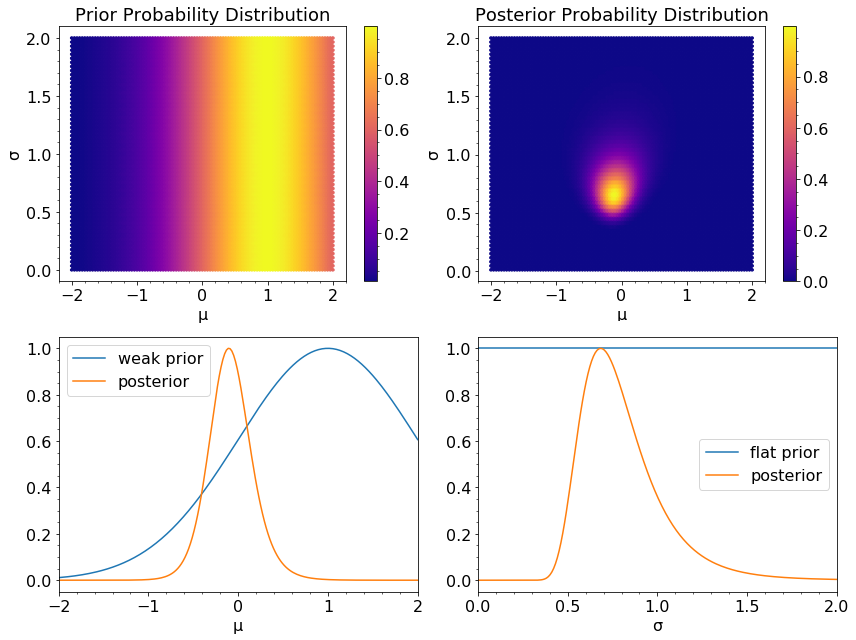

In [24]:
f , axp = pl.subplots(ncols=2, nrows=2, figsize=(12, 9))
axp = axp.ravel()
plot_posterior(df_grid_1, axp[0], axp[1])
plot_marginals(df_grid_1, axp[2], axp[3])
axp[2].legend(['weak prior', 'posterior'])
axp[3].legend(['flat prior', 'posterior'])
f.tight_layout()
f.savefig('./figJar/Presentation/grid3.svg')

<img src="./figJar/Presentation/grid3.svg?modified=3"/>

2. $\mu \sim \mathcal{N}(-1.5, 0.1)$, $\sigma \sim \mathcal{U}(0, 2)$ - a strongly informative prior

In [25]:
strong_prior=dict(μ_mean=-1.5, μ_sd=.1, σ_lo=0, σ_hi=2)
df_grid_2 = compute_bayes_framework(df_data_s, priors_dict=strong_prior)

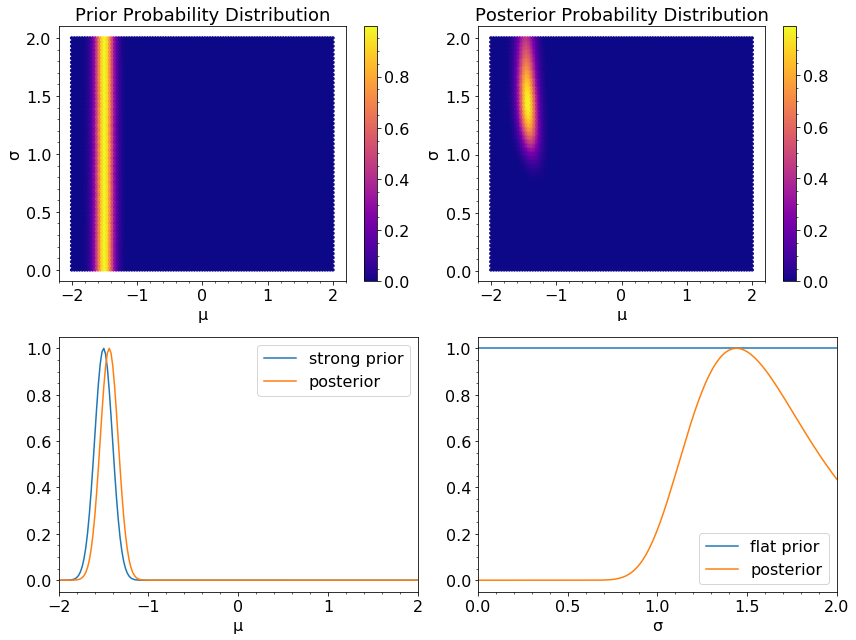

In [26]:
f , axp = pl.subplots(ncols=2, nrows=2, figsize=(12, 9))
axp = axp.ravel()
plot_posterior(df_grid_2, axp[0], axp[1])
plot_marginals(df_grid_2, axp[2], axp[3])
axp[2].legend(['strong prior', 'posterior'])
axp[3].legend(['flat prior', 'posterior'])
f.tight_layout()
f.savefig('./figJar/Presentation/grid4.svg')

<img src="./figJar/Presentation/grid4.svg?modified=1"/>

[Back to Contents](#TOP)
<a id='DataImpact'></a>

### Impact of data set size
* sub-sample size is now 500 samples,
* same two priors used

In [27]:
sample_N = 500

# compute the inference dataframe
df_data_s = df_data.dropna().sample(n=sample_N)

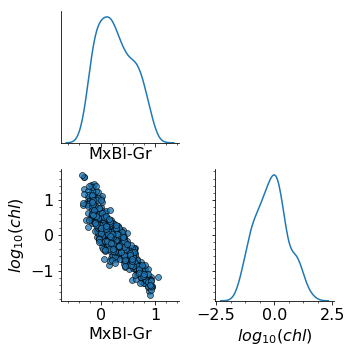

In [28]:
# display the new sub-sample
g = sb.PairGrid(df_data_s.loc[:,['MxBl-Gr', 'chl_l']],
                diag_sharey=False)
g.map_diag(sb.kdeplot, )
g.map_offdiag(sb.scatterplot, alpha=0.75, edgecolor='k');
make_lower_triangle(g)
g.axes[1,0].set_ylabel(r'$log_{10}(chl)$');
g.axes[1,1].set_xlabel(r'$log_{10}(chl)$');

In [29]:
%%time
df_grid_3 = compute_bayes_framework(df_data_s, priors_dict=weak_prior)

CPU times: user 1.34 s, sys: 1.43 s, total: 2.77 s
Wall time: 7.83 s


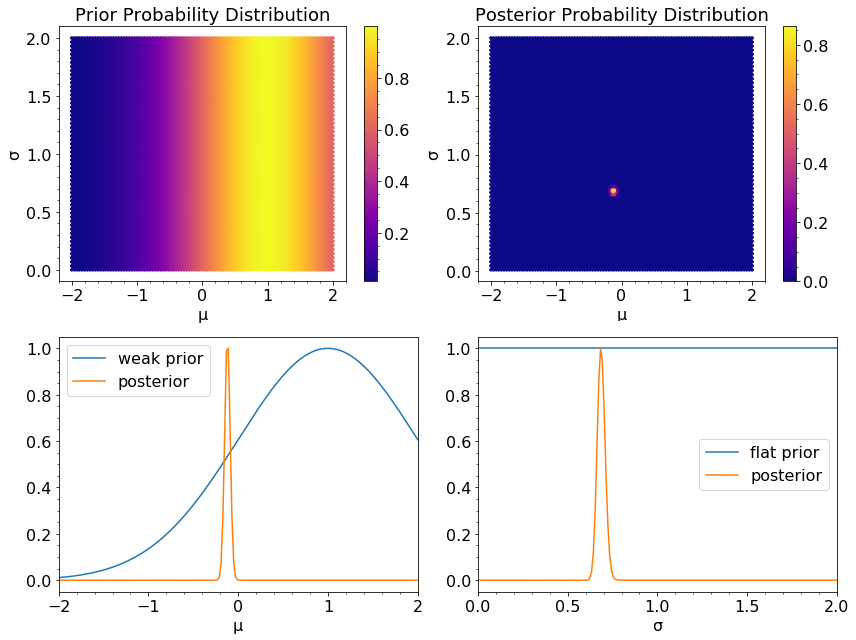

In [30]:
f , axp = pl.subplots(ncols=2, nrows=2, figsize=(12, 9))
axp = axp.ravel()
plot_posterior(df_grid_3, axp[0], axp[1])
plot_marginals(df_grid_3, axp[2], axp[3])
axp[2].legend(['weak prior', 'posterior'])
axp[3].legend(['flat prior', 'posterior'])
f.tight_layout()
f.savefig('./figJar/Presentation/grid5.svg')

<img src="./figJar/Presentation/grid5.svg?modified=4"/>

In [31]:
df_grid_4 = compute_bayes_framework(df_data_s, priors_dict=strong_prior)

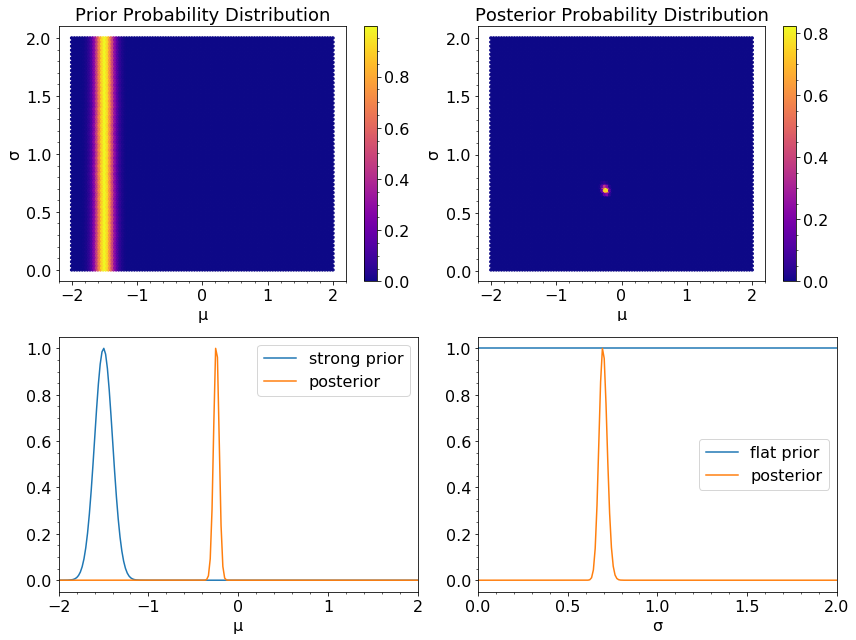

In [32]:
f , axp = pl.subplots(ncols=2, nrows=2, figsize=(12, 9))
axp = axp.ravel()
plot_posterior(df_grid_4, axp[0], axp[1])
plot_marginals(df_grid_4, axp[2], axp[3])
axp[2].legend(['strong prior', 'posterior'])
axp[3].legend(['flat prior', 'posterior'])
f.tight_layout()
f.savefig('./figJar/Presentation/grid6.svg')

<img src="./figJar/Presentation/grid6.svg?modified=8"/>

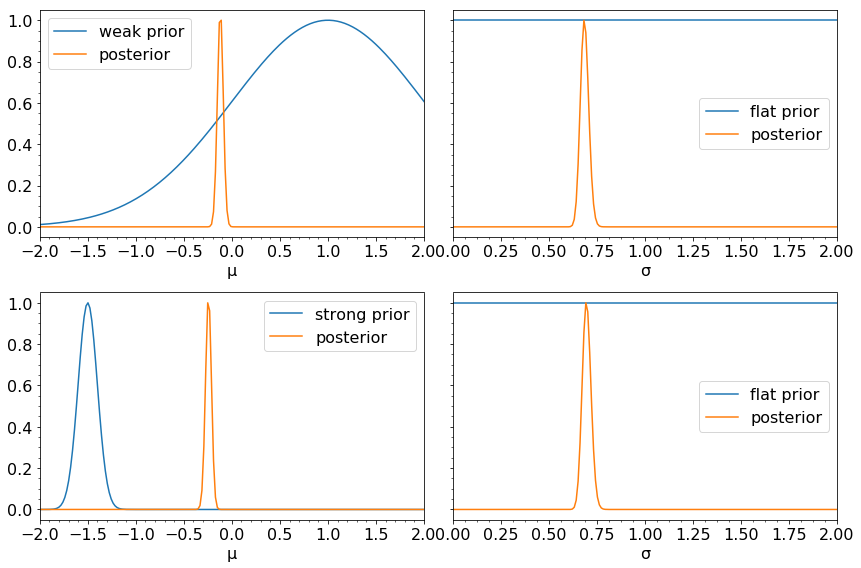

In [33]:
f , axp = pl.subplots(ncols=2, nrows=2, figsize=(12, 8), sharey=True)
axp = axp.ravel()
plot_marginals(df_grid_3, axp[0], axp[1])
plot_marginals(df_grid_4, axp[2], axp[3])
axp[0].legend(['weak prior', 'posterior'])
axp[1].legend(['flat prior', 'posterior'])
axp[2].legend(['strong prior', 'posterior'])
axp[3].legend(['flat prior', 'posterior'])
f.tight_layout()
f.savefig('./figJar/Presentation/grid7.svg')

<img src="./figJar/Presentation/grid7.svg?modified=4"/>

***And using all the data?***

In [34]:
%%time
priors=dict(μ_mean=-1.5, μ_sd=.1, σ_lo=0, σ_hi=2)
try:
    df_grid_all_data= compute_bayes_framework(df_data, priors_dict=priors)
except MemoryError:
    print("OUT OF MEMORY!")
    print("--------------")

OUT OF MEMORY!
--------------
CPU times: user 536 ms, sys: 702 ms, total: 1.24 s
Wall time: 4.85 s


## Under the hood: Inferring chlorophyll distribution

* ~~Grid approximation: computing probability everywhere~~
* <font color='red'>Magical MCMC: Dealing with computational complexity</font>
* Probabilistic Programming with PyMC3: Industrial grade MCMC

[Back to Contents](#TOP)
<a id="MCMC"></a>

### Magical MCMC: Dealing with computational complexity

* Grid approximation:
    * useful for understanding mechanics of Bayesian computation
    * computationally intensive
    * impractical and often intractable for large data sets or high-dimension models

    
* MCMC allows sampling <u>where it **probabilistically matters**</u>:
    * compute current probability given location in parameter space
    * propose jump to new location in parameter space
    * compute new probability at proposed location
    * jump to new location if $\frac{new\ probability}{current\ probability}>1$ 
    * jump to new location if $\frac{new\ probability}{current\ probability}>\gamma\in [0, 1]$
    * otherwise stay in current location

In [35]:
def mcmc(data, μ_0=0.5, n_samples=1000,):
    print(f'{data.size} data points')
    data = data.reshape(1, -1)
    # set priors
    σ=0.75 # keep σ fixed for simplicity
    trace_μ = np.nan * np.ones(n_samples) # trace: where the sampler has been
    trace_μ[0] = μ_0 # start with a first guess
    for i in range(1, n_samples):
        proposed_μ = norm.rvs(loc=trace_μ[i-1], scale=0.1, size=1)
        prop_par_dict = dict(μ=proposed_μ, σ=σ)
        curr_par_dict = dict(μ=trace_μ[i-1], σ=σ)
        log_prob_prop = get_log_lik(data, prop_par_dict
                                   ) + get_log_prior(prop_par_dict)
        log_prob_curr = get_log_lik(data, curr_par_dict
                                   ) + get_log_prior(curr_par_dict) 
        ratio = np.exp(log_prob_prop -  log_prob_curr)
        if ratio > 1:
            # accept proposal
            trace_μ[i] = proposed_μ
        else:
            # evaluate low proba proposal
            if uniform.rvs(size=1, loc=0, scale=1) > ratio:
                # reject proposal
                trace_μ[i] = trace_μ[i-1]    
            else:
                # accept proposal
                trace_μ[i] = proposed_μ
    return trace_μ

In [36]:
 def get_log_lik(data, param_dict):
    return np.sum(norm.logpdf(data, loc=param_dict['μ'],
                              scale=param_dict['σ']
                             ),
                  axis=1)

def get_log_prior(par_dict, loc=1, scale=1):
    return norm.logpdf(par_dict['μ'], loc=loc, scale=scale)

#### Timing MCMC

In [37]:
%%time
mcmc_n_samples = 2000
trace1 = mcmc(data=df_data_s.chl_l.values, n_samples=mcmc_n_samples)

500 data points
CPU times: user 1.65 s, sys: 32.4 ms, total: 1.68 s
Wall time: 1.74 s


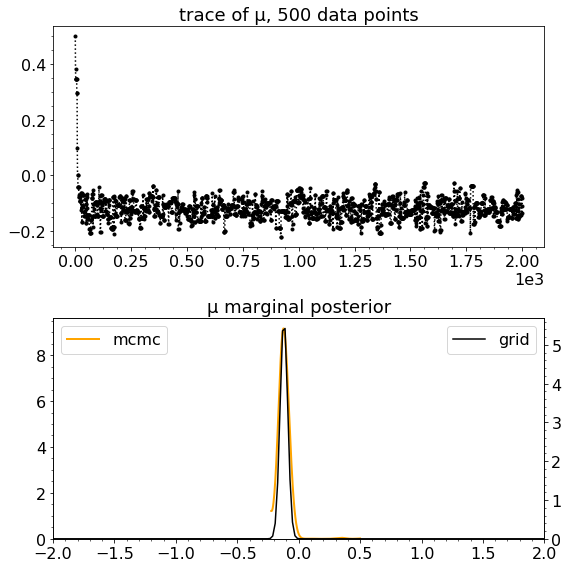

In [38]:
f, ax = pl.subplots(nrows=2, figsize=(8, 8))
ax[0].plot(np.arange(mcmc_n_samples), trace1, marker='.',
           ls=':', color='k')
ax[0].set_title('trace of μ, 500 data points')
ax[1].set_title('μ marginal posterior')
pm.plots.kdeplot(trace1, ax=ax[1], label='mcmc',
                 color='orange', lw=2, zorder=1)
ax[1].legend(loc='upper left')
ax[1].set_ylim(bottom=0)
df_μ = df_grid_3.groupby(['μ']).sum().drop('σ',
                                     axis=1)[['post_prob']
                                            ].reset_index()
ax2 = ax[1].twinx()
df_μ.plot(x='μ', y='post_prob', ax=ax2, color='k',
         label='grid',)
ax2.set_ylim(bottom=0);
ax2.legend(loc='upper right')
f.tight_layout()

f.savefig('./figJar/Presentation/mcmc_1.svg')

<img src='./figJar/Presentation/mcmc_1.svg?modified="1"'>

In [39]:
%%time
samples = 2000
trace2 = mcmc(data=df_data.chl_l.values, n_samples=samples)

4459 data points
CPU times: user 2.7 s, sys: 4.03 ms, total: 2.7 s
Wall time: 2.7 s


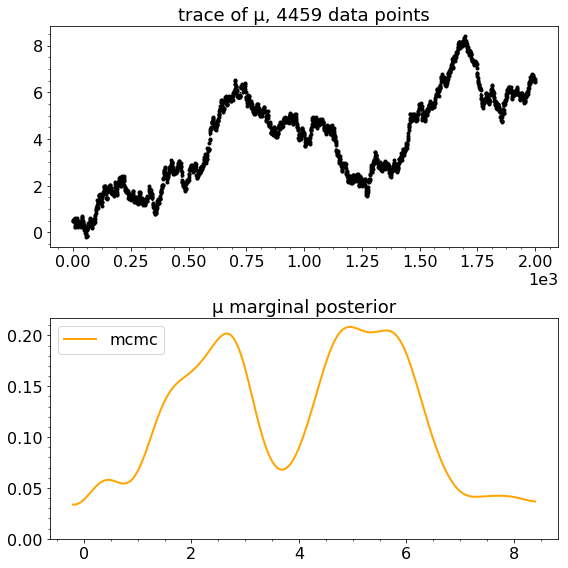

In [40]:
f, ax = pl.subplots(nrows=2, figsize=(8, 8))
ax[0].plot(np.arange(samples), trace2, marker='.',
           ls=':', color='k')
ax[0].set_title(f'trace of μ, {df_data.chl_l.size} data points')
ax[1].set_title('μ marginal posterior')
pm.plots.kdeplot(trace2, ax=ax[1], label='mcmc',
                 color='orange', lw=2, zorder=1)
ax[1].legend(loc='upper left')
ax[1].set_ylim(bottom=0)
f.tight_layout()
f.savefig('./figJar/Presentation/mcmc_2.svg')

<img src='./figJar/Presentation/mcmc_2.svg?modified=2'>

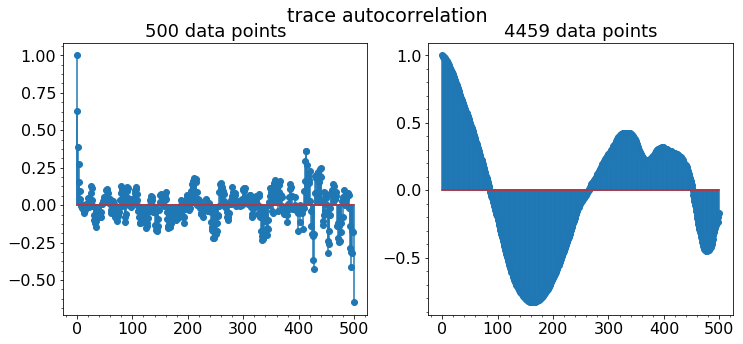

In [41]:
f, ax = pl.subplots(ncols=2, figsize=(12, 5))
ax[0].stem(pm.autocorr(trace1[1500:]))
ax[1].stem(pm.autocorr(trace2[1500:]))
ax[0].set_title(f'{df_data_s.chl_l.size} data points')
ax[1].set_title(f'{df_data.chl_l.size} data points')
f.suptitle('trace autocorrelation', fontsize=19)
f.savefig('./figJar/Presentation/grid8.svg')

<img src="./figJar/Presentation/grid8.svg"/>

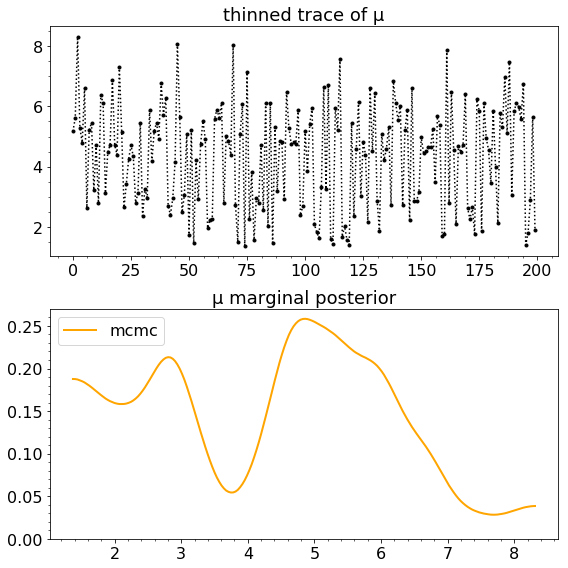

In [42]:
f, ax = pl.subplots(nrows=2, figsize=(8, 8))
thinned_trace = np.random.choice(trace2[100:], size=200, replace=False)
ax[0].plot(np.arange(200), thinned_trace, marker='.',
           ls=':', color='k')
ax[0].set_title('thinned trace of μ')
ax[1].set_title('μ marginal posterior')
pm.plots.kdeplot(thinned_trace, ax=ax[1], label='mcmc',
                 color='orange', lw=2, zorder=1)
ax[1].legend(loc='upper left')
ax[1].set_ylim(bottom=0)
f.tight_layout()
f.savefig('./figJar/Presentation/grid9.svg')

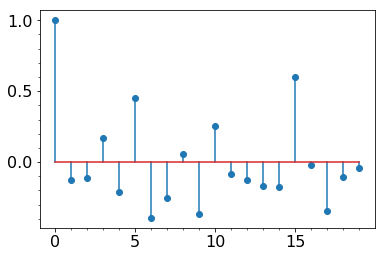

In [43]:
f, ax = pl.subplots()
ax.stem(pm.autocorr(thinned_trace[:20]));
f.savefig('./figJar/Presentation/stem2.svg', dpi=300, format='svg');

What's going on?

Highly autocorrelated trace: <br>
$\rightarrow$ inadequate parameter space exploration<br>
$\rightarrow$ poor convergence...

<table><tr>
    <td><img src='./figJar/Presentation/stem1.svg'></td>
    <td><img src='./figJar/Presentation/stem2.svg'></td>
    </tr>
</table>

Metropolis MCMC<br>
    $\rightarrow$ easy to implement + memory efficient<br>
    $\rightarrow$ inefficient parameter space exploration<br>
    $\rightarrow$ better MCMC sampler?

* **Hamiltonian Monte Carlo (HMC)**
* Greatly improved convergence
* Well mixed traces are a signature and an easy diagnostic
* HMC does require a lot of tuning,
* Not practical for the inexperienced applied statistician or scientist

* No-U-Turn Sampler (NUTS), HMC that automates most tuning steps
* NUTS  scales well to complex problems with many parameters (1000's)
* Implemented in popular libraries

##### Probabilistic modeling for the beginner
* <font color='red'>Under the hood: Inferring chlorophyll distribution</font>
    * ~~Grid approximation: computing probability everywhere~~
    * ~~MCMC: how it works~~
    * <font color='red'>Probabilistic Programming with PyMC3: Industrial grade MCMC </font>

[Back to Contents](#TOP)
<a id='PyMC3'></a> 

### <u>Probabilistic Programming with PyMC3</u>

* relatively simple syntax
* easily used in conjuction with mainstream python scientific data structures<br>
    $\rightarrow$numpy arrays <br>
    $\rightarrow$pandas dataframes
* models of reasonable complexity span ~10-20 lines.

In [44]:
with pm.Model() as m1:
    μ_ = pm.Normal('μ', mu=1, sd=1)
    σ = pm.Uniform('σ', lower=0, upper=2)
    lkl = pm.Normal('likelihood', mu=μ_, sd=σ,
                    observed=df_data.chl_l.dropna())

In [45]:
graph_m1 = pm.model_to_graphviz(m1)
graph_m1.format = 'svg'
graph_m1.render('./figJar/Presentation/graph_m1');

<center>
<img src="./figJar/Presentation/graph_m1.svg"/>
</center>

In [46]:
with m1:
    trace_m1 = pm.sample(2000, tune=1000, chains=4)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 2 jobs)
NUTS: [σ, μ]
Sampling 4 chains: 100%|██████████| 12000/12000 [00:10<00:00, 1186.54draws/s]


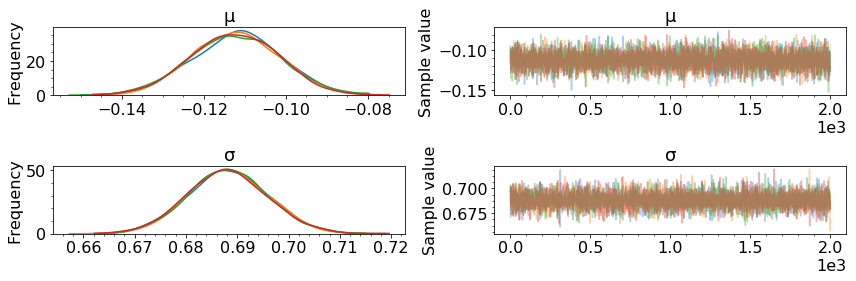

In [47]:
pm.traceplot(trace_m1);

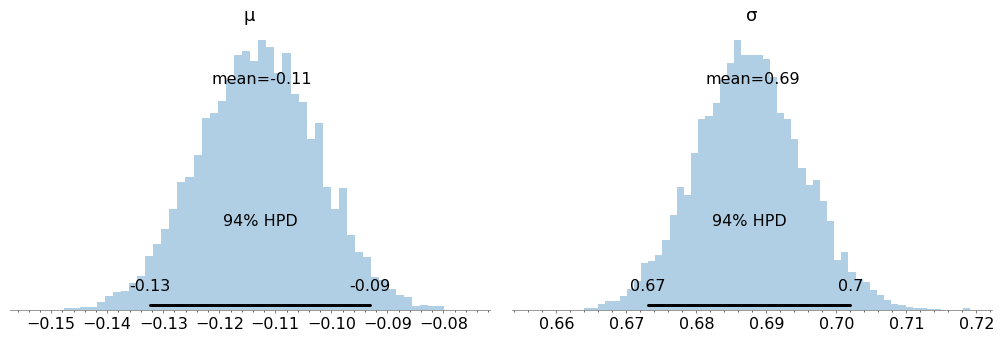

In [48]:
ar.plot_posterior(trace_m1, kind='hist', round_to=2);

[Back to Contents](#TOP)

<a id='Reg'></a>

#### <u><font color='purple'>Tutorial Overview:</font></u>
* Probabilistic modeling for the beginner<br>
    $\rightarrow$~~The basics~~<br>
    $\rightarrow$~~Starting easy: inferring chlorophyll~~<br>
    <font color='red'>$\rightarrow$Regression: adding a predictor to estimate chlorophyll</font>

[Back to Contents](#TOP)
<a id='DataPrep'></a>

## Regression: Adding a  predictor to estimate chlorophyll

* <font color=red>Data preparation</font>
* Writing a regression model in PyMC3
* Are my priors making sense?
* Model fitting
* Flavors of uncertainty

Linear regression takes the form

$$ y = \alpha + \beta x $$
where 
        $$\ \ \ \ \ y = log_{10}(chl)$$ and $$x = log_{10}\left(\frac{Gr}{MxBl}\right)$$


In [49]:
df_data.head().T

,0,1,2,3,4
rrs411_l,-2.48181,-2.69759,-2.57346,-2.74698,-2.85684
rrs443_l,-2.39369,-2.57914,-2.48391,-2.66945,-2.77425
rrs489_l,-2.32961,-2.44558,-2.39021,-2.56902,-2.6778
rrs510_l,-2.29265,-2.38804,-2.36096,-2.5593,-2.70144
rrs555_l,-2.26695,-2.36376,-2.34046,-2.59924,-2.80625
rrs670_l,-3.07818,-3.13471,-3.16042,-3.50443,-3.79611
mxBl_l,-2.29265,-2.38804,-2.36096,-2.5593,-2.6778
mxBlId,rrs510,rrs510,rrs510,rrs510,rrs489
MxBl-Gr,-0.0257098,-0.0242776,-0.0205022,0.0399411,0.128449
mxBlColor,#4eb3d3,#4eb3d3,#4eb3d3,#4eb3d3,#2b8cbe


In [50]:
df_data['Gr-MxBl'] = -1 * df_data['MxBl-Gr']

Regression coefficients easier to interpret with centered predictor:<br><br>
$$x_c = x - \bar{x}$$

In [51]:
df_data['Gr-MxBl_c'] = df_data['Gr-MxBl'] - df_data['Gr-MxBl'].mean()

In [52]:
df_data[['Gr-MxBl_c', 'chl_l']].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4459 entries, 0 to 4458
Data columns (total 2 columns):
Gr-MxBl_c    4453 non-null float64
chl_l        4127 non-null float64
dtypes: float64(2)
memory usage: 104.5 KB


In [53]:
x_c = df_data.dropna()['Gr-MxBl_c'].values
y = df_data.dropna().chl_l.values

$$ y = \alpha + \beta x_c$$<br>
$\rightarrow \alpha=y$ when $x=\bar{x}$<br>
$\rightarrow \beta=\Delta y$ when $x$ increases by one unit

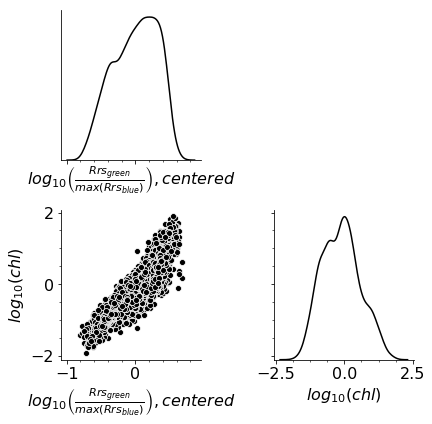

In [54]:
g3 = sb.PairGrid(df_data.loc[:, ['Gr-MxBl_c', 'chl_l']], height=3,
                         diag_sharey=False,)
g3.map_diag(sb.kdeplot, color='k')
g3.map_offdiag(sb.scatterplot, color='k');
make_lower_triangle(g3)
f = pl.gcf()
axs = f.get_axes()
xlabel = r'$log_{10}\left(\frac{Rrs_{green}}{max(Rrs_{blue})}\right), centered$'
ylabel = r'$log_{10}(chl)$'
axs[0].set_xlabel(xlabel)
axs[2].set_xlabel(xlabel)
axs[2].set_ylabel(ylabel)
axs[3].set_xlabel(ylabel)
f.tight_layout()
f.savefig('./figJar/Presentation/pairwise_1.png')

<center>
<img src='./figJar/Presentation/pairwise_1.png?modif=1' width="50%">
</center>

[Back to Contents](#TOP)
<a id='RegPyMC3'></a>

## Regression: Adding a  predictor to estimate chlorophyll

* ~~Data preparation~~
* <font color=red>Writing a regression model in PyMC3</font>
* Are my priors making sense?
* Model fitting
* Flavors of uncertainty

In [55]:
with pm.Model() as m_vague_prior:
    # priors
    σ = pm.Uniform('σ', lower=0, upper=2)
    α = pm.Normal('α', mu=0, sd=1)
    β = pm.Normal('β', mu=0, sd=1)
    # deterministic model
    μ = α + β * x_c
    # likelihood
    chl_i = pm.Normal('chl_i', mu=μ, sd=σ, observed=y)

In [56]:
graph = pm.model_to_graphviz(m_vague_prior)
graph.format='svg'
graph.render('./figJar/Presentation/m_vague_graph');

<center>
<img src="./figJar/Presentation/m_vague_graph.svg"/>
</center>

[Back to Contents](#TOP)
<a id='PriorCheck'></a>

## Regression: Adding a  predictor to estimate chlorophyll
* ~~Data preparation~~
* ~~Writing a regression model in PyMC3~~
* <font color=red>Are my priors making sense?</font>
* Model fitting 
* Flavors of uncertainty

In [57]:
vague_priors = pm.sample_prior_predictive(samples=500, model=m_vague_prior, vars=['α', 'β',])

In [58]:
x_dummy = np.linspace(-1.5, 1.5, num=50).reshape(-1, 1)

In [59]:
α_prior_vague = vague_priors['α'].reshape(1, -1)
β_prior_vague = vague_priors['β'].reshape(1, -1)
chl_l_prior_μ_vague = α_prior_vague + β_prior_vague * x_dummy

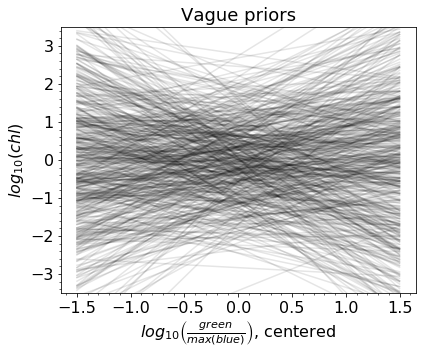

In [60]:
f, ax = pl.subplots( figsize=(6, 5))
ax.plot(x_dummy, chl_l_prior_μ_vague, color='k', alpha=0.1,);
ax.set_xlabel(r'$log_{10}\left(\frac{green}{max(blue)}\right)$, centered')
ax.set_ylabel('$log_{10}(chl)$')
ax.set_title('Vague priors')
ax.set_ylim(-3.5, 3.5)
f.tight_layout(pad=1)
f.savefig('./figJar/Presentation/prior_checks_1.png')

<center>
<img src='./figJar/Presentation/prior_checks_1.png?modified=3' width=65%>
</center

In [61]:
with pm.Model() as m_informative_prior:
    α = pm.Normal('α', mu=0, sd=0.2)
    β = pm.Normal('β', mu=0, sd=0.5)
    σ = pm.Uniform('σ', lower=0, upper=2)
    μ = α + β * x_c
    chl_i = pm.Normal('chl_i', mu=μ, sd=σ, observed=y)

In [62]:
prior_info = pm.sample_prior_predictive(model=m_informative_prior, vars=['α', 'β'])

In [63]:
α_prior_info = prior_info['α'].reshape(1, -1)
β_prior_info = prior_info['β'].reshape(1, -1)
chl_l_prior_info = α_prior_info + β_prior_info * x_dummy

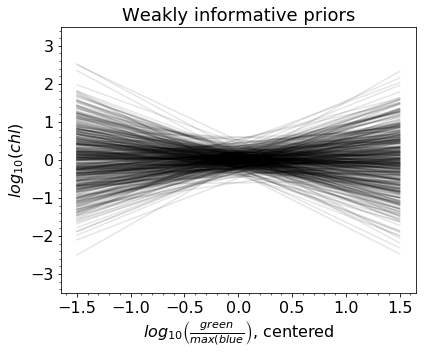

In [64]:
f, ax = pl.subplots( figsize=(6, 5))
ax.plot(x_dummy, chl_l_prior_info, color='k', alpha=0.1,);
ax.set_xlabel(r'$log_{10}\left(\frac{green}{max(blue}\right)$, centered')
ax.set_ylabel('$log_{10}(chl)$')
ax.set_title('Weakly informative priors')
ax.set_ylim(-3.5, 3.5)
f.tight_layout(pad=1)
f.savefig('./figJar/Presentation/prior_checks_2.png')

<center>
<img src='./figJar/Presentation/prior_checks_2.png?modif=2' width="65%" />
</center>

<table>
    <tr>
        <td>
            <img src='./figJar/Presentation/prior_checks_1.png?modif=1' />
        </td>
        <td>
            <img src='./figJar/Presentation/prior_checks_2.png?modif=2' />
        </td>
    </tr>
</table>


[Back to Contents](#TOP)
<a id='Mining'></a>

## Regression: Adding a  predictor to estimate chlorophyll
* ~~Data preparatrion~~
* ~~Writing a regression model in PyMC3~~
* ~~Are my priors making sense?~~
* <font color=red>Model fitting</font>
* Flavors of uncertainty

In [65]:
with m_vague_prior:
    trace_vague = pm.sample(2000, tune=1000, chains=4)

with m_informative_prior:
    trace_inf = pm.sample(2000, tune=1000, chains=4)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 2 jobs)
NUTS: [β, α, σ]
Sampling 4 chains: 100%|██████████| 12000/12000 [00:12<00:00, 931.15draws/s] 
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 2 jobs)
NUTS: [σ, β, α]
Sampling 4 chains: 100%|██████████| 12000/12000 [00:12<00:00, 940.39draws/s] 


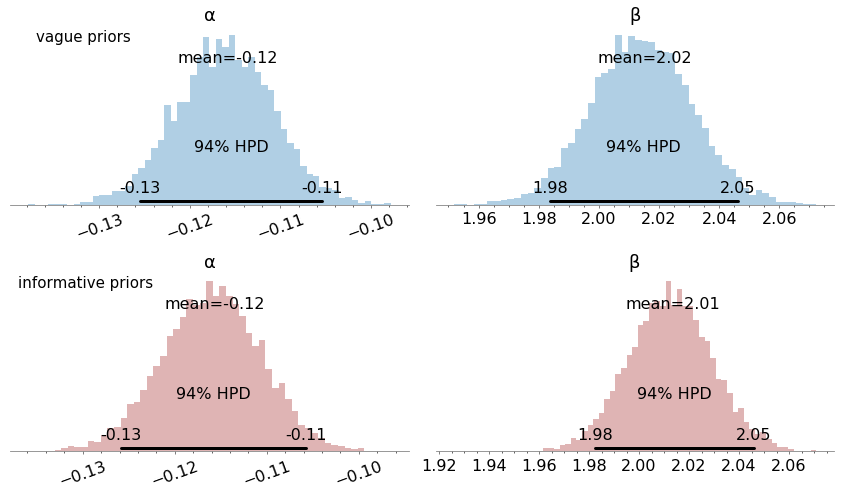

In [66]:
f, axs = pl.subplots(ncols=2, nrows=2, figsize=(12, 7))
ar.plot_posterior(trace_vague, var_names=['α', 'β'], round_to=2, ax=axs[0,:], kind='hist');
ar.plot_posterior(trace_inf, var_names=['α', 'β'], round_to=2, ax=axs[1, :], kind='hist',
                                        color='brown');
axs[0,0].tick_params(rotation=20)
axs[0,0].text(-0.137, 430, 'vague priors',
              fontdict={'fontsize': 15})
axs[1,0].tick_params(rotation=20)
axs[1,0].text(-0.137, 430, 'informative priors',
              fontdict={'fontsize': 15})
f.tight_layout()
f.savefig('./figJar/Presentation/reg_posteriors.svg')

<center>
<img src='./figJar/Presentation/reg_posteriors.svg'/>
</center>

[Back to Contents](#TOP)
<a id='UNC'></a>

## Regression: Adding a  predictor to estimate chlorophyll
* ~~Data preparation~~
* ~~Writing a regression model in PyMC3~~
* ~~Are my priors making sense?~~
* ~~Data review and model fitting~~
* <font color=red>Flavors of uncertainty</font>

Two types of uncertainties:
1. model uncertainty
2. prediction uncertainty

In [67]:
α_posterior = trace_inf.get_values('α').reshape(1, -1)
β_posterior = trace_inf.get_values('β').reshape(1, -1)
σ_posterior = trace_inf.get_values('σ').reshape(1, -1)

1. model uncertainty: uncertainty around the model mean

In [68]:
μ_posterior = α_posterior + β_posterior * x_dummy

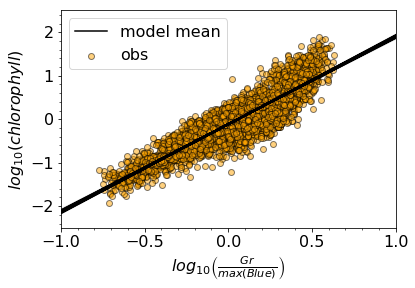

In [69]:
pl.plot(x_dummy, μ_posterior[:, ::16], color='k', alpha=0.1);
pl.plot(x_dummy, μ_posterior[:, 1], color='k', label='model mean')

pl.scatter(x_c, y, color='orange', edgecolor='k', alpha=0.5, label='obs'); pl.legend();
pl.ylim(-2.5, 2.5); pl.xlim(-1, 1);
pl.xlabel(r'$log_{10}\left(\frac{Gr}{max(Blue)}\right)$')
pl.ylabel(r'$log_{10}(chlorophyll)$')
f = pl.gcf()
f.savefig('./figJar/Presentation/mu_posterior.svg')

<center>
    <img src='./figJar/Presentation/mu_posterior.svg/'>
</center>     

2. prediction uncertainty: posterior predictive checks

In [70]:
ppc = norm.rvs(loc=μ_posterior, scale=σ_posterior);
ci_94_perc = pm.hpd(ppc.T, alpha=0.06);

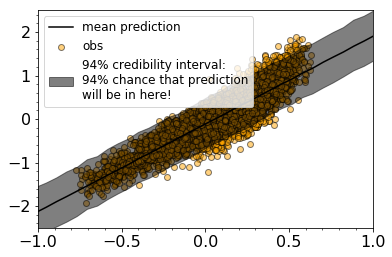

In [71]:
pl.scatter(x_c, y, color='orange', edgecolor='k', alpha=0.5, label='obs'); pl.legend();
pl.plot(x_dummy, ppc.mean(axis=1), color='k', label='mean prediction');
pl.fill_between(x_dummy.flatten(), ci_94_perc[:, 0], ci_94_perc[:, 1], alpha=0.5, color='k',
               label='94% credibility interval:\n94% chance that prediction\nwill be in here!');
pl.xlim(-1, 1); pl.ylim(-2.5, 2.5)
pl.legend(fontsize=12, loc='upper left')
f = pl.gcf()
f.savefig('./figJar/Presentation/ppc.svg')

<center>
    <img src='./figJar/Presentation/ppc.svg/' width="70%"/>
</center> 

[Back to Contents](#TOP)
<a id="Conclusion"></a>

### In Conclusion Probabilistic Programming provides:
* Transparent modeling:
    * Explicit assumptions
    * Easy to debate/criticize
    * Easy to communicate/reproduce/improve upon
* Posterior distribution much richer construct than point estimates
* Principled estimation of model and prediction uncertainty
* Accessibility
    * Constantly improving algorithms
    * Easy-to-use software
    * Flexible framework, largely problem-agnostic

<table><tr>
    <td><img src='./figJar/Presentation/krusche_diagrams_hs_reg.png?modif=2'/></td>
    <td><img src='./figJar/Presentation/krusche_diagrams_BNN.png?modif=1'/></td>
    </tr>
    </table>

[Back to Contents](#TOP)
<a id="Next"></a>

## To be continued...


<center>
<img src="./figJar/Presentation/bayes.jpg" width=60%>
</center>